In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36541980.37it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1033325.32it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8017551.01it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3102691.98it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

input_size = 28 * 28
hidden_size = 512
num_classes = 10
model = NeuralNetwork(input_size, hidden_size, num_classes)


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 1  Avg loss: 0.12
Validation Results - Epoch: 1  Avg loss: 0.13


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 2  Avg loss: 0.08
Validation Results - Epoch: 2  Avg loss: 0.11


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 3  Avg loss: 0.07
Validation Results - Epoch: 3  Avg loss: 0.11


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 4  Avg loss: 0.04
Validation Results - Epoch: 4  Avg loss: 0.09


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 5  Avg loss: 0.03
Validation Results - Epoch: 5  Avg loss: 0.08


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 6  Avg loss: 0.08
Validation Results - Epoch: 6  Avg loss: 0.15


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 7  Avg loss: 0.02
Validation Results - Epoch: 7  Avg loss: 0.10


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 8  Avg loss: 0.03
Validation Results - Epoch: 8  Avg loss: 0.09


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 9  Avg loss: 0.02
Validation Results - Epoch: 9  Avg loss: 0.09


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 10  Avg loss: 0.02
Validation Results - Epoch: 10  Avg loss: 0.11


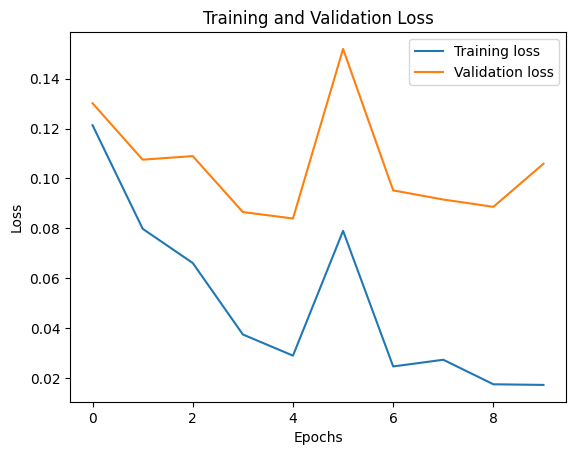

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(model, 
                                        metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, 
                                        device=device)

# Setting up progress bar
pbar = ProgressBar(persist=True)
pbar.attach(trainer)

# Storing losses for visualization
train_losses = []
val_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    train_loss = metrics['loss']
    train_losses.append(train_loss)
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg loss: {train_loss:.2f}")
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    val_loss = metrics['loss']
    val_losses.append(val_loss)
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {val_loss:.2f}")

# Adding early stopping
handler = EarlyStopping(patience=5, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Training
trainer.run(train_dataloader, max_epochs=10)

# Plotting losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


Saved PyTorch Model State to ml_with_pytorch_model.pth


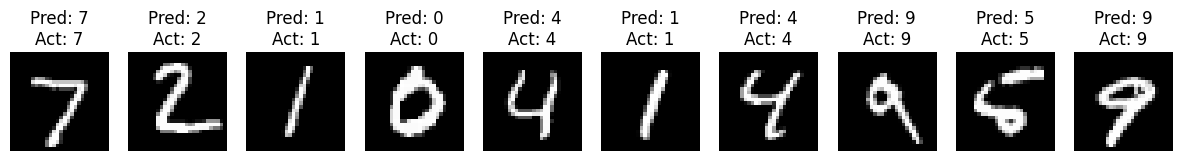

In [7]:
torch.save(model.state_dict(), "ml_with_pytorch_model.pth")
print("Saved PyTorch Model State to ml_with_pytorch_model.pth")

model = NeuralNetwork(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load("ml_with_pytorch_model.pth"))
model.to(device)

model.eval()
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        x = x.unsqueeze(0).to(device)
        pred = model(x)
        predicted, actual = pred[0].argmax(0).item(), y
    
    axes[i].imshow(x.cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'Pred: {predicted}\nAct: {actual}')
    axes[i].axis('off')

plt.show()